# Step 1 : Importing Libraries

In [1]:
import librosa #used for audio processing tasks
import librosa.display #provides functions for visualizing audio data
import numpy as np #used for numerical computations
import matplotlib.pyplot as plt #used for creating static and interactive visualizations
from matplotlib.pyplot import specgram
import pandas as pd #package for data manipulation and library analysis
import glob #used for file operations and pathname pattern matching
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #used for normalization of data
from sklearn.neighbors import KNeighborsClassifier #required for KNN model
from sklearn.svm import SVC #required for SVM model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.externals import joblib #used for model serialization
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import IPython.display as ipd #used for displaying audio signals
from tqdm import tqdm #progress bar
import seaborn as sns #used for visualization
import pickle #used for serialization and of Python objects
import os #used for file operations and manipulating environment variables
import sys

import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Step 2 : Loading Datasets

We are using four datasets specialized for emotion classification. The four datasets are as follows:
* TESS (Toronto Emotional Speech Set)
* RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song)
* SAVEE (Surrey Audio Visual Expressed Emotion)
* CREMA-D (Crowd Sourced Emotional Multimodal Actors Dataset)

The above datasets are slightly re-structured to satisfy the required folder structure.

In [2]:
# Traversing the directory tree rooted at the input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# Defining the paths to the datasets
TESS = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
RAV = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
SAVEE = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
CREMA = "/kaggle/input/cremad/AudioWAV/"

## Step 2.1 : Exploring SAVEE Dataset

male_neutral     120
male_sad          60
male_disgust      60
male_surprise     60
male_fear         60
male_angry        60
male_happy        60
Name: labels, dtype: int64



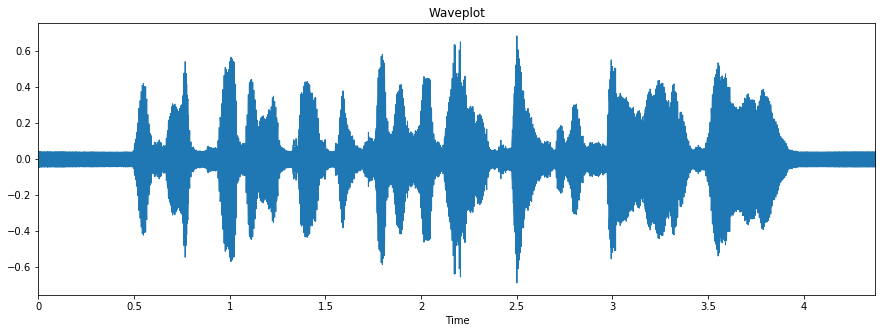

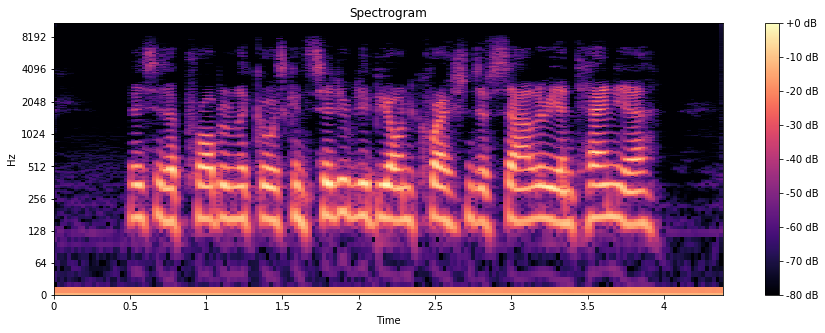

In [3]:
dir_list = os.listdir(SAVEE)

# List initialization to store emotions and file paths
emotion =[]
path = []

for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error') 
    path.append(SAVEE + i)

# Dataframe creation to store emotion labels, file paths and source dataset
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
print(SAVEE_df.labels.value_counts())
print() #for an extra line

#Testing an audio sample - SAVEE
fname = SAVEE + 'DC_f12.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
plt.title('Waveplot') # Displaying Waveplot

plt.figure(figsize=(15, 5))
D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram') # Displaying Spectogram
plt.show()

ipd.Audio(fname) # Audio Playback

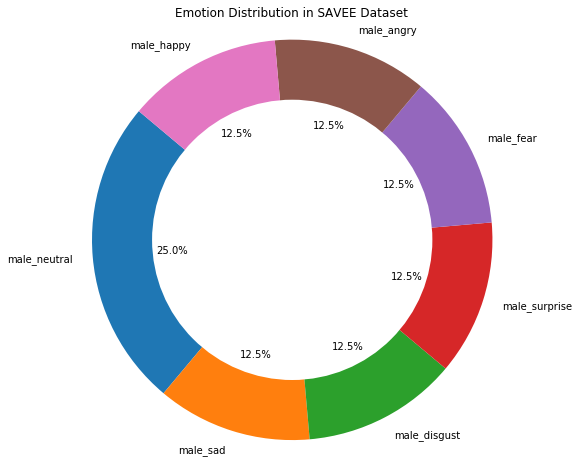

In [4]:
# Count the occurrences of each emotion label
emotion_counts = SAVEE_df['labels'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4))
# Draw a white circle at the center to make it a "donut" chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Emotion Distribution in SAVEE Dataset')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


## Step 2.2 : Exploring RAVDESS Dataset

female_neutral     144
male_neutral       144
male_surprise       96
male_angry          96
female_disgust      96
male_sad            96
female_fear         96
female_sad          96
male_disgust        96
male_fear           96
female_surprise     96
female_happy        96
female_angry        96
male_happy          96
Name: labels, dtype: int64



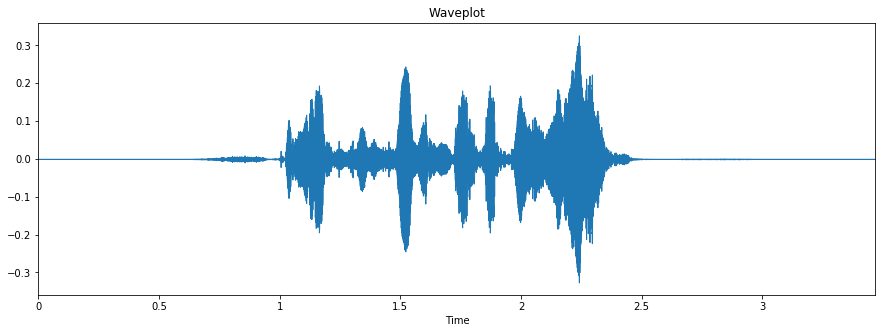

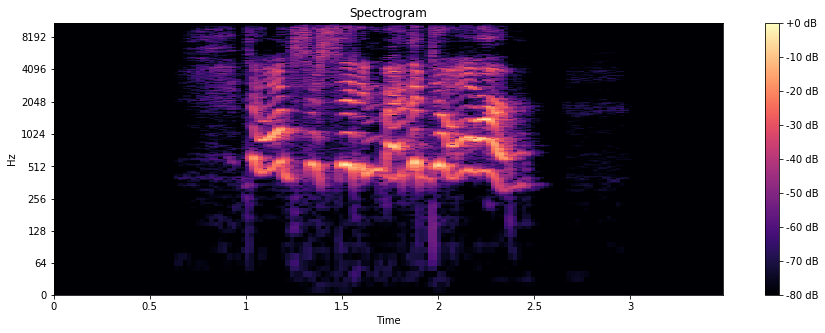

In [5]:
dir_list = os.listdir(RAV)
dir_list.sort()

# List initialization to store emotions and file paths
emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)
        
# Dataframe creation to store emotion labels, file paths and source dataset
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad',
                         5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
print(RAV_df.labels.value_counts())
print() # for extra new line

#Testing an audio sample - RAVDESS
fname = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
plt.title('Waveplot') # Displaying Waveplot

plt.figure(figsize=(15, 5))
D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram') # Displaying Spectogram
plt.show()

ipd.Audio(fname) # Audio Playback

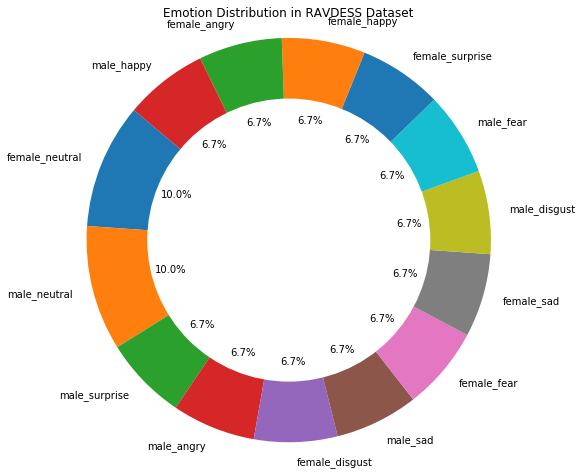

In [6]:
# Count the occurrences of each emotion label
emotion_counts = RAV_df['labels'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4))
# Draw a white circle at the center to make it a "donut" chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Emotion Distribution in RAVDESS Dataset')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


## Step 2.3 : Exploring TESS Dataset

female_angry       400
female_surprise    400
female_disgust     400
female_fear        400
female_sad         400
female_neutral     400
female_happy       400
Name: labels, dtype: int64



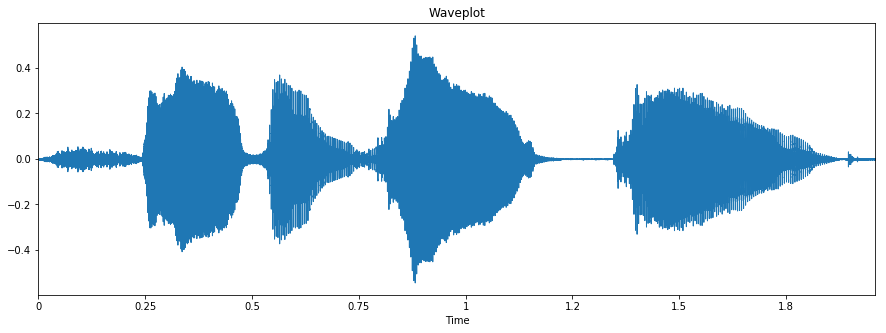

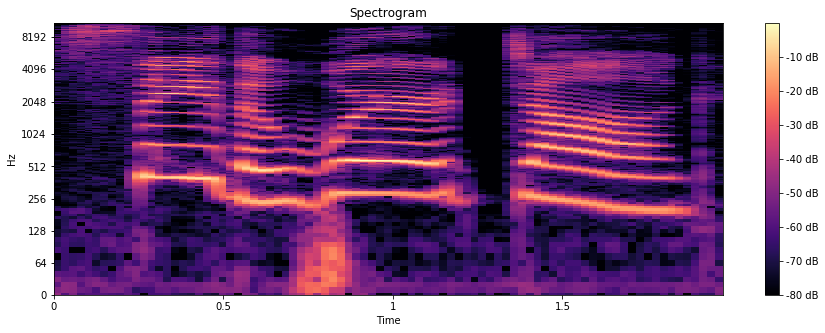

In [7]:
dir_list = os.listdir(TESS)
dir_list.sort()

# List initialization to store emotions and file paths
path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('female_neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('female_surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('female_sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

# Dataframe creation to store emotion labels, file paths and source dataset
TESS_df = pd.DataFrame(emotion, columns = ['labels']) 
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
print(TESS_df.labels.value_counts())
print() # for an extra line

#Testing an audio sample - TESS
fname = TESS + 'YAF_happy/YAF_dog_happy.wav'

data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
plt.title('Waveplot') # Displaying Waveplot

plt.figure(figsize=(15, 5))
D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram') # Displaying Spectogram
plt.show()

ipd.Audio(fname) # Audio Playback

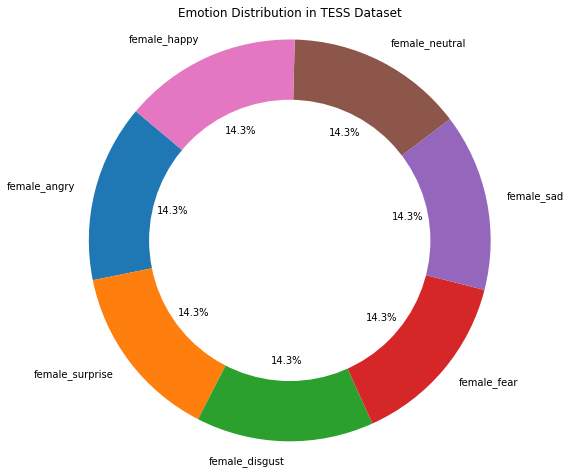

In [8]:
# Count the occurrences of each emotion label
emotion_counts = TESS_df['labels'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4))
# Draw a white circle at the center to make it a "donut" chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Emotion Distribution in TESS Dataset')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


## Step 2.4 : Exploring CREMA-D Dataset

male_angry        671
male_fear         671
male_sad          671
male_disgust      671
male_happy        671
female_angry      600
female_disgust    600
female_fear       600
female_sad        600
female_happy      600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64



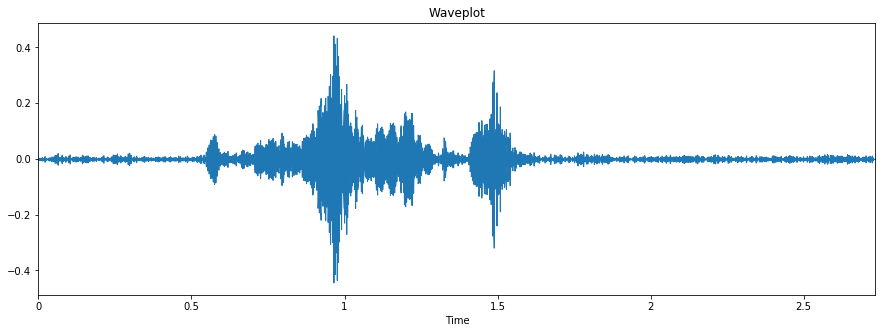

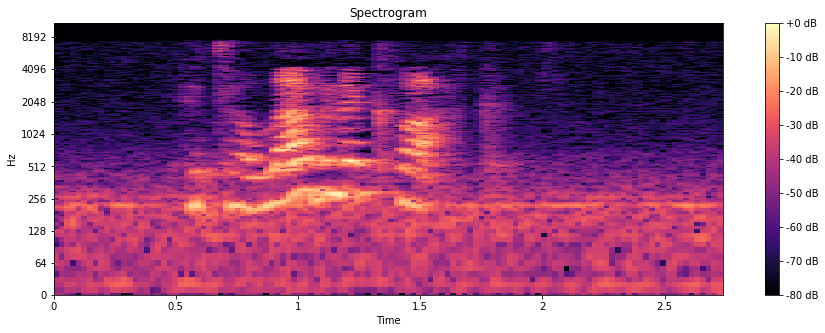

In [9]:
dir_list = os.listdir(CREMA)
dir_list.sort()

# List initialization to store emotions and file paths
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,
          1029,1030,1037,1043,1046,1047,1049,1052, 1053,1054,1055,1056,1058,1060,1061,1063, 1072,1073,1074,1075,1076,1078,1079,1082,
          1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)


#Dataframe creation to store emotion labels, file paths and source dataset
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
print(CREMA_df.labels.value_counts())
print() # for an extra line

#Testing an audio sample - CREMA-D
fname = CREMA + '1012_IEO_HAP_HI.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
plt.title('Waveplot') # Displaying Waveplot

plt.figure(figsize=(15, 5))
D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram') # Displaying Spectogram
plt.show()

ipd.Audio(fname) # Audio Playback

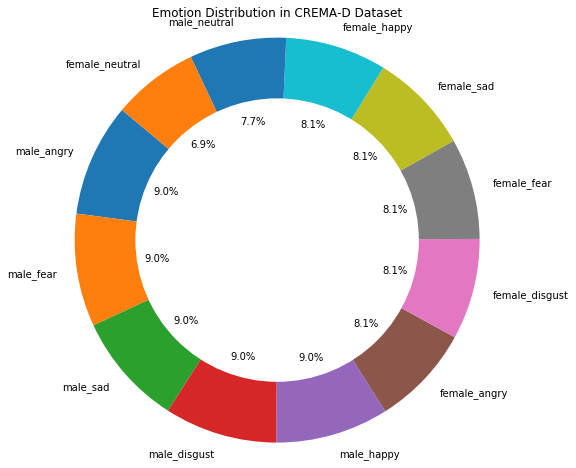

In [10]:
# Count the occurrences of each emotion label
emotion_counts = CREMA_df['labels'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4))
# Draw a white circle at the center to make it a "donut" chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Emotion Distribution in CREMA-D Dataset')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


## Step 2.5 : Combining the data

In total, from the four datasets we have 12,162 audio samples

female_happy       1096
female_disgust     1096
female_angry       1096
female_fear        1096
female_sad         1096
female_neutral     1056
male_neutral        839
male_angry          827
male_fear           827
male_disgust        827
male_sad            827
male_happy          827
female_surprise     496
male_surprise       156
Name: labels, dtype: int64
None


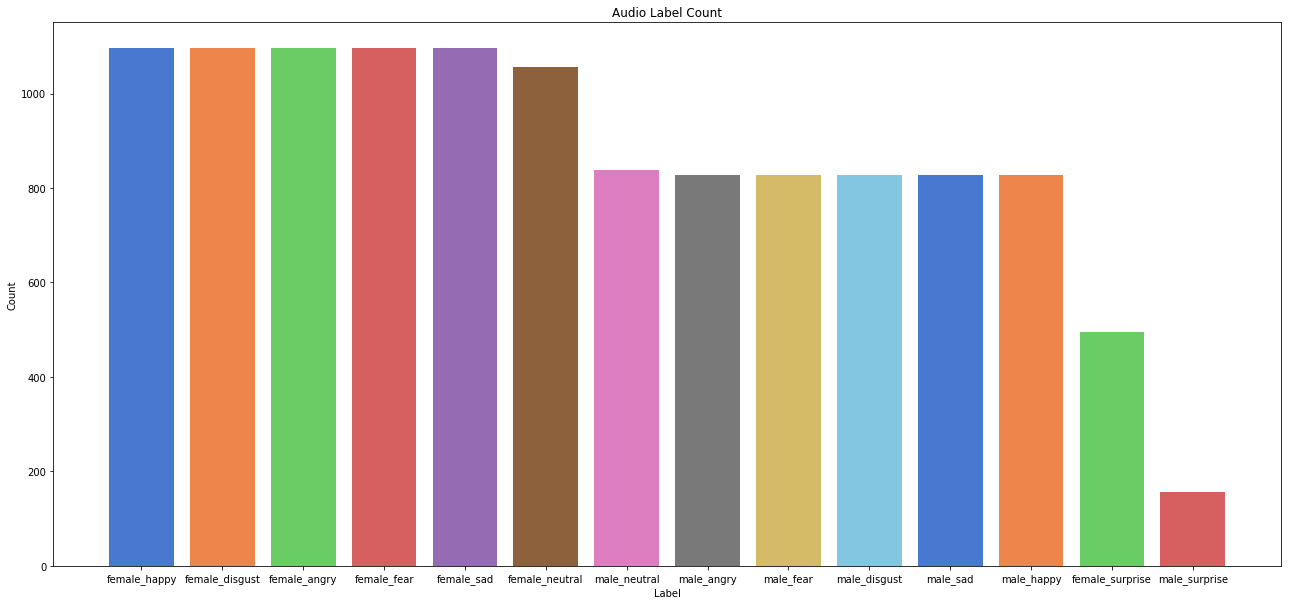

In [11]:
# Concatenate dataframes from different emotion datasets into a single dataframe
df = pd.concat([SAVEE_df, RAV_df, TESS_df, CREMA_df], axis = 0)

# Count the occurrences of each audio label
audio_label_count = df.labels.value_counts()
print(audio_label_count)
print(df.to_csv("Data_path.csv",index=False)) # Saving the combined dataframe to a CSV file


# Generating bar plot
colors = ['blue', 'green', 'red', 'purple', 'orange',
          'yellow', 'pink', 'brown', 'gray', 'cyan',
          'magenta', 'olive', 'teal', 'navy']
pastel_colors = sns.color_palette("muted", len(colors))

plt.figure(figsize=(22, 10))
plt.bar(audio_label_count.index, audio_label_count.values, color=pastel_colors)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Audio Label Count')
plt.xticks(audio_label_count.index)
plt.show()

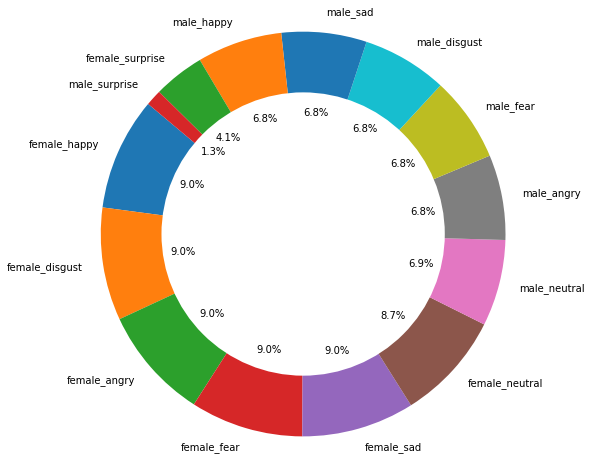

In [12]:
# Count the occurrences of each emotion label
emotion_counts = df['labels'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4))
# Draw a white circle at the center to make it a "donut" chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


# Step 4 : Data Processing

We are using MFCC Feature Extraction Method. The complete data processing took around 14 minutes as it is iterating over 4 datasets.

In [13]:
ref = pd.read_csv("/kaggle/working/Data_path.csv")
num_mfcc = 20  # Number of MFCC coefficients
num_files = 12162  # Number of audio files

# Dataframe initialization
columns = ['mfcc_' + str(i+1) for i in range(num_mfcc)]
df = pd.DataFrame(columns=columns, index=range(num_files))
pbar = tqdm(total=num_files) # Progress bar

# Loop through audio files and extract MFCC features
for idx, path in enumerate(ref.path):  
    #Loading the audio file from the specified path and extracting MFCC features
    X, sample_rate = librosa.load(path, res_type='kaiser_fast', duration=2.5, sr=44100, offset=0.5)
    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=num_mfcc)
    
    mfccs_mean = np.mean(mfccs, axis=1)  # Compute mean of MFCC coefficients along each column
    df.loc[idx] = mfccs_mean # Storing the mean coefficients in the dataframe
    pbar.update(1)
    
pbar.close()

100%|██████████| 12162/12162 [09:48<00:00, 22.01it/s]


In [14]:
print(df.shape)
#Concatenating the two dataframes to match the mfcc features 
#of a particular audio file to its emotion label
df_concat = pd.concat([ref, df], axis=1)
# Filling any missing values(NaN) in the dataframe with zero.
# This is done for easier handling of missing data.
df_concat=df_concat.fillna(0)
df_concat.to_csv('features.csv', index=False)
print(df_concat.shape)
df_concat[:5]

(12162, 20)
(12162, 23)


labels source                                               path  \
0    male_happy  SAVEE  /kaggle/input/surrey-audiovisual-expressed-emo...   
1     male_fear  SAVEE  /kaggle/input/surrey-audiovisual-expressed-emo...   
2    male_happy  SAVEE  /kaggle/input/surrey-audiovisual-expressed-emo...   
3  male_disgust  SAVEE  /kaggle/input/surrey-audiovisual-expressed-emo...   
4    male_angry  SAVEE  /kaggle/input/surrey-audiovisual-expressed-emo...   

       mfcc_1      mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6  \
0 -309.609619  156.562469  12.748092  24.563248   5.987000 -13.370072   
1 -621.123352  161.778122  35.570583  36.647305  25.223625  -0.475460   
2 -344.603577  113.925369  15.898048  13.738302  21.520544  13.897222   
3 -402.221893  133.746902  24.931446  36.427547  42.442593  18.489746   
4 -549.466125  154.088684  12.996944  21.621086  28.807652   4.498013   

     mfcc_7  ...    mfcc_11    mfcc_12   mfcc_13   mfcc_14   mfcc_15  \
0 -0.902566  ... -16.751169   0.902141  2.987767 -8.257284 -1.060103   
1 -0.188156  ... -13.794344  -9.369884 -3.399983 -3.791615 -1.427450   
2 -0.368703  ...  -6.870913  -9.739623 -0.659857  1.005181 -0.994036   
3  0.040821  ...  -6.487161 -17.031794 -1.840788  1.950772 -4.698260   
4 -2.225336  ...  -7.490743  -8.456983 -0.670760 -3.446213 -3.872377   

    mfcc_16   mfcc_17   mfcc_18   mfcc_19   mfcc_20  
0 -4.434721 -5.881765  4.145817 -2.087474 -8.433018  
1  1.159548  0.605723 -0.375765  4.168525  4.737456  
2 -4.372424  1.068029  4.855748 -4.877567 -3.713228  
3 -1.198288  9.812835  8.472905 -2.847432  0.185765  
4  4.194579  3.619041 -2.480716  1.123396  2.933870  

[5 rows x 23 columns]

# Step 5 : Splitting and Normalizing the Dataset

In [15]:
extracted_features = pd.read_csv("/kaggle/working/features.csv")

X_train, X_test, y_train, y_test = train_test_split(extracted_features.drop(['path','labels','source'],
                                                                   axis=1)
                                                    , df_concat.labels
                                                    , test_size=0.20
                                                    , shuffle=True
                                                    , random_state=42 # Random seed for reproducibility
                                                   )

print(X_train.shape)
print(X_test.shape)

(9729, 20)
(2433, 20)


In [16]:
# Normalization of training and testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6 : Model Creation and Accuracy Measurement

## Step 6.1 : KNN MODEL

In [17]:
#KNN classifier
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')  

# Training
knn.fit(X_train_scaled, y_train)

# Predict labels 
y_pred = knn.predict(X_test_scaled)

# Evaluating the classifier and calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4940402794903411


In [19]:
def plot_confusion_matrix(model, X, y, display_labels=None, cmap=plt.cm.Blues):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    
    if display_labels is None:
        display_labels = np.unique(y)
    
    # Plotting
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(display_labels))
    plt.xticks(tick_marks, display_labels, rotation=45)
    plt.yticks(tick_marks, display_labels)
    
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [20]:
def plot_learning_curve(estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=train_sizes, cv=cv)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()


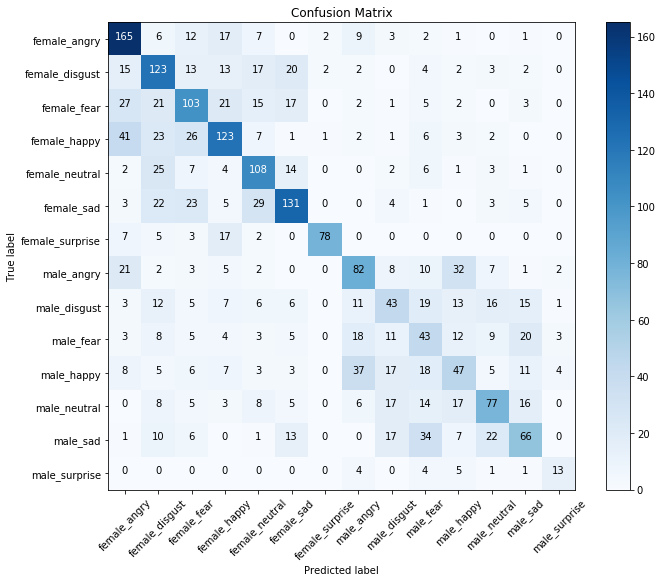

In [21]:
plot_confusion_matrix(knn, X_test_scaled, y_test)

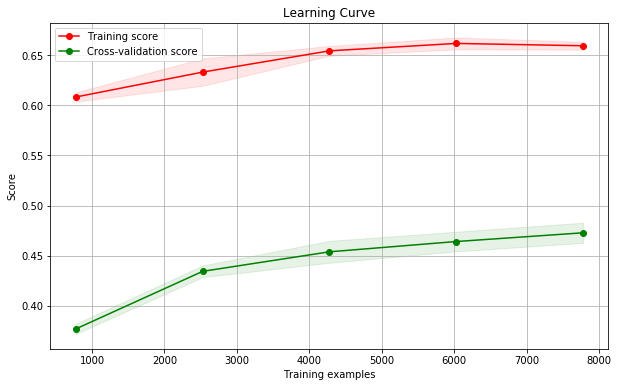

In [22]:
plot_learning_curve(knn, X_train_scaled, y_train)

In [23]:
# Saving the trained model to disk
joblib.dump(knn, 'knn_model.pkl')
print("Model saved at: /kaggle/working/")

Model saved at: /kaggle/working/


## Step 6.2 : LSTM MODEL

In [24]:
# Reshape input data for LSTM
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# One-hot encode the labels
label_binarizer = LabelBinarizer()
y_train_one_hot = label_binarizer.fit_transform(y_train)
y_test_one_hot = label_binarizer.transform(y_test)
num_classes = 14

# Defining the LSTM model
lstm_model = Sequential([
    LSTM(units=128, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  # Use 'softmax' activation for multi-class classification
])

# Compiling the model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = lstm_model.fit(X_train_reshaped, y_train_one_hot, epochs=100, batch_size=16, validation_data=(X_test_reshaped, y_test_one_hot))

# Evaluating the model and calculate accuracy
loss, accuracy = lstm_model.evaluate(X_test_reshaped, y_test_one_hot)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Train on 9729 samples, validate on 2433 samples
Epoch 1/100
9729/9729 [==============================] - 4s 418us/sample - loss: 2.0521 - acc: 0.2885 - val_loss: 1.6891 - val_acc: 0.4196
Epoch 2/100
9729/9729 [==============================] - 3s 295us/sample - loss: 1.6673 - acc: 0.4087 - val_loss: 1.5287 - val_acc: 0.4562
Epoch 3/100
9729/9729 [==============================] - 3s 294us/sample - loss: 1.5558 - acc: 0.4418 - val_loss: 1.4557 - val_acc: 0.4797
Epoch 4/100
9729/9729 [==============================] - 3s 290us/sample - loss: 1.5024 - acc: 0.4608 - val_loss: 1.4072 - val_acc: 0.4973
Epoch 5/100
9729/9729 [==============================] - 3s 290us/sample - loss: 1.4575 - acc: 0.4732 - val_loss: 1.3772 - val_acc: 0.5006
Epoch 6/100
9729/9729 [==============================] - 3s 316us/sample - loss: 1.4313 - acc: 0.4796 - val_loss: 1.3514 - val_acc: 0.5076
Epoch 7/100
9729/9729 [==============================] - 3s 293us/sample - loss: 1.4028 - acc: 0.4885 - val_loss: 1.32

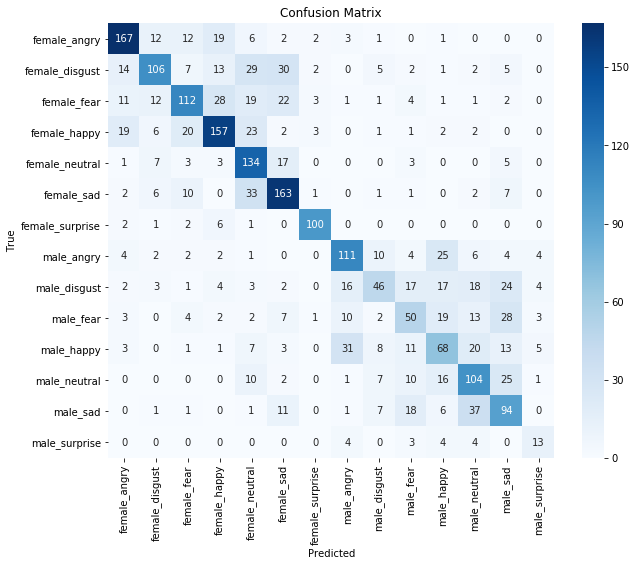

In [25]:
# Predict probabilities for the test set
y_pred_probs = lstm_model.predict(X_test_reshaped)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=label_binarizer.classes_, yticklabels=label_binarizer.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

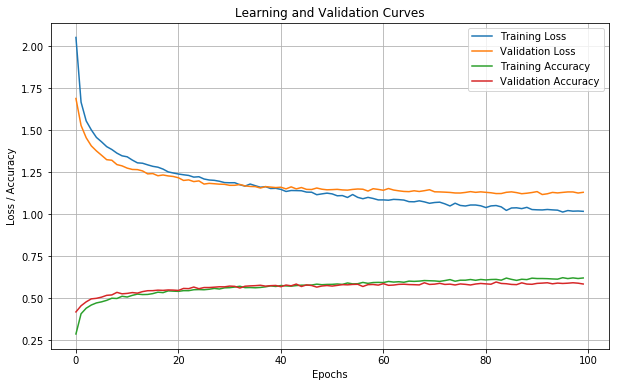

In [26]:
# Plot learning and validation curves on the same graph
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Learning and Validation Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Make predictions on the test set
y_pred = lstm_model.predict_classes(X_test_reshaped)
# Convert one-hot encoded labels to integers
y_test_classes = np.argmax(y_test_one_hot, axis=1)
# Generate classification report
classification_rep = classification_report(y_test_classes, y_pred)
# Print the classification report
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.74       225
           1       0.68      0.49      0.57       216
           2       0.64      0.52      0.57       217
           3       0.67      0.67      0.67       236
           4       0.50      0.77      0.61       173
           5       0.62      0.72      0.67       226
           6       0.89      0.89      0.89       112
           7       0.62      0.63      0.63       175
           8       0.52      0.29      0.37       157
           9       0.40      0.35      0.37       144
          10       0.42      0.40      0.41       171
          11       0.50      0.59      0.54       176
          12       0.45      0.53      0.49       177
          13       0.43      0.46      0.45        28

    accuracy                           0.59      2433
   macro avg       0.58      0.58      0.57      2433
weighted avg       0.59      0.59      0.58      2433



In [28]:
#Saving model to disk
model_path = "lstm_model.h5"
lstm_model.save(model_path)

print("Model saved at /kaggle/working/")

Model saved at /kaggle/working/


## Step 6.3 : SVM MODEL

In [29]:
X_train_array = np.array(X_train)
X_test_array = np.array(X_test)

# Reshape the array if necessary
X_train_flattened = X_train_array.reshape(X_train_array.shape[0], -1)
X_test_flattened = X_test_array.reshape(X_test_array.shape[0], -1)

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the SVM classifier
svm_classifier.fit(X_train_flattened, y_train)

# Predict labels for test data
y_pred_svm = svm_classifier.predict(X_test_flattened)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy_svm)

Accuracy: 0.45170571311138513


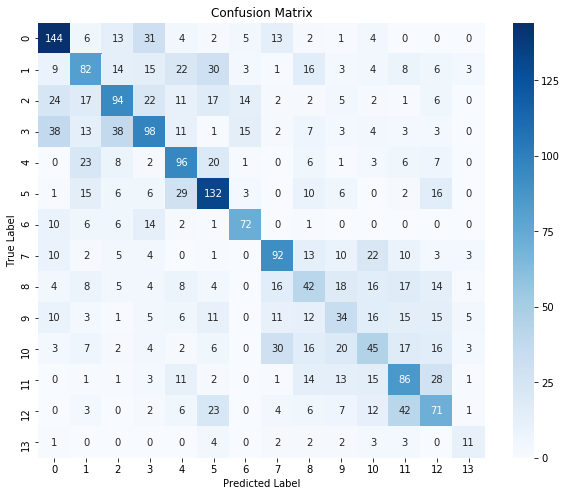

In [30]:
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [31]:
joblib.dump(svm_classifier, 'svm_model.pkl')
print("Model saved at /kaggle/working/")

Model saved at /kaggle/working/


# Step 7 : Testing Unknown Sample

In [32]:
# Load the LSTM model from disk
lstm_model = tf.keras.models.load_model('/kaggle/working/lstm_model.h5')

# Display model summary
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               76288     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 14)                910       
Total params: 85,454
Trainable params: 85,454
Non-trainable params: 0
_________________________________________________________________
None


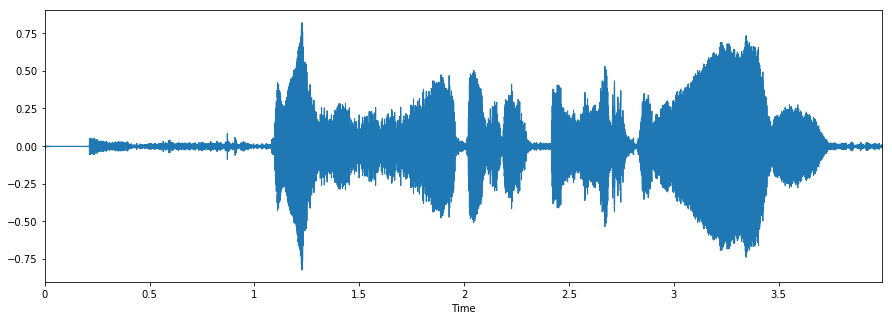

In [33]:
data, sampling_rate = librosa.load('/kaggle/input/sample-data/download.wav')
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
ipd.Audio('/kaggle/input/sample-data/download.wav')

In [34]:
X, sample_rate = librosa.load('/kaggle/input/sample-data/download.wav'
                              ,res_type='kaiser_fast'
                              ,duration=2.5
                              ,sr=44100
                              ,offset=0.5
                             )

sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=20),axis=1)
newdf = pd.DataFrame(data=mfccs).T
newdf

0           1          2          3          4         5  \
0 -261.770142  102.957771  20.218884  29.012108 -42.481544  3.894803   

           6         7         8          9       10        11        12  \
0 -18.923239  7.973177 -0.114891 -20.090012 -3.46461 -1.496974 -7.582504   

         13        14        15        16        17         18        19  
0 -7.292804  5.815145  6.164321  5.876423  9.265319  12.028216  8.165927

In [35]:
X_scaled = scaler.transform(newdf)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
X_reshaped

array([[[ 2.30923408, -1.32615041,  1.49617757, -0.34634693,
         -3.16768637,  0.6655817 , -2.03780125,  1.92118395,
          0.96961191, -1.64268616,  0.57666922,  0.21922159,
         -0.91950303, -0.31653151,  1.32203574,  1.95082518,
          2.50705578,  2.237857  ,  4.06392575,  4.04348317]]])

In [36]:
# Predict emotion class
predicted_class = lstm_model.predict_classes(X_reshaped)

predicted_labels = []
for index in predicted_class:
    if index == 0:
        predicted_labels.append("female_happy")
    elif index == 1:
        predicted_labels.append("female_fear")
    elif index == 2:
        predicted_labels.append("female_sad")
    elif index == 3:
        predicted_labels.append("female_disgust")
    elif index == 4:
        predicted_labels.append("female_angry")
    elif index == 5:
        predicted_labels.append("female_neutral")
    elif index == 6:
        predicted_labels.append("male_neutral")
    elif index == 7:
        predicted_labels.append("male_sad")
    elif index == 8:
        predicted_labels.append("male_disgust")
    elif index == 9:
        predicted_labels.append("male_fear")
    elif index == 10:
        predicted_labels.append("male_happy")
    elif index == 11:
        predicted_labels.append("male_angry")
    elif index == 12:
        predicted_labels.append("female_surprise")
    elif index == 13:
        predicted_labels.append("male_surprise")

print("Predicted Emotion Class: ")
print(predicted_labels)

Predicted Emotion Class: 
['male_disgust']


# Classifying with 7 classes

## Database Creation

neutral     120
angry        60
disgust      60
fear         60
sad          60
surprise     60
happy        60
Name: labels, dtype: int64



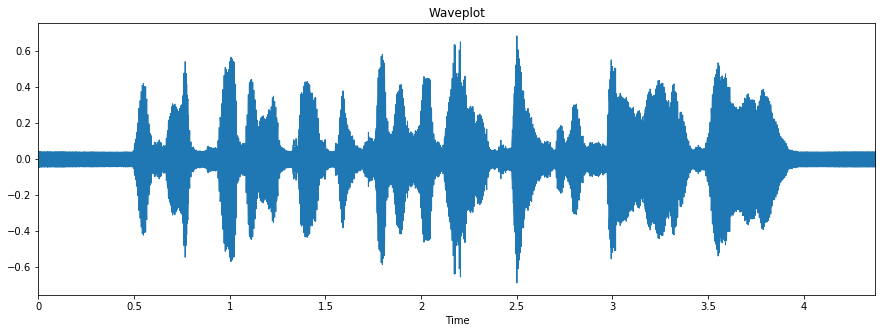

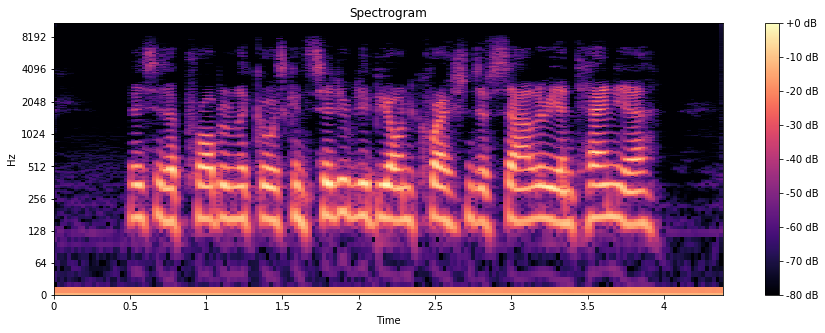

In [37]:
dir_list = os.listdir(SAVEE)

# List initialization to store emotions and file paths
emotion =[]
path = []

for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('angry')
    elif i[-8:-6]=='_d':
        emotion.append('disgust')
    elif i[-8:-6]=='_f':
        emotion.append('fear')
    elif i[-8:-6]=='_h':
        emotion.append('happy')
    elif i[-8:-6]=='_n':
        emotion.append('neutral')
    elif i[-8:-6]=='sa':
        emotion.append('sad')
    elif i[-8:-6]=='su':
        emotion.append('surprise')
    else:
        emotion.append('error') 
    path.append(SAVEE + i)

# Dataframe creation to store emotion labels, file paths and source dataset
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
print(SAVEE_df.labels.value_counts())
print() #for an extra line

#Testing an audio sample - SAVEE
fname = SAVEE + 'DC_f12.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
plt.title('Waveplot') # Displaying Waveplot

plt.figure(figsize=(15, 5))
D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram') # Displaying Spectogram
plt.show()

ipd.Audio(fname) # Audio Playback

neutral     288
fear        192
sad         192
surprise    192
angry       192
disgust     192
happy       192
Name: labels, dtype: int64



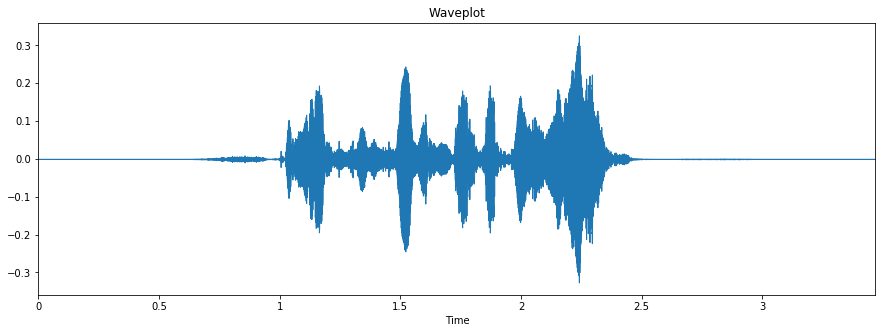

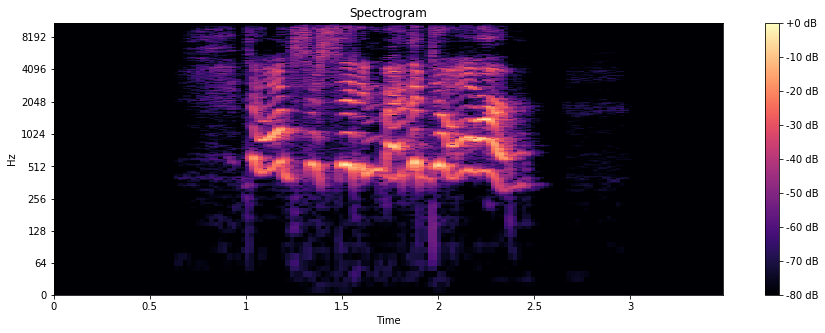

In [38]:
dir_list = os.listdir(RAV)
dir_list.sort()

# List initialization to store emotions and file paths
labels = []
path = []

for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        labels.append(int(part[2]))
        path.append(RAV + i + '/' + f)

# Dataframe creation to store emotion labels, file paths, and source dataset
RAV_df = pd.DataFrame(labels)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad',
                         5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df.columns = ['labels']
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
print(RAV_df.labels.value_counts())
print() # for extra new line

# Testing an audio sample - RAVDESS
fname = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
plt.title('Waveplot') # Displaying Waveplot

plt.figure(figsize=(15, 5))
D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram') # Displaying Spectogram
plt.show()

ipd.Audio(fname) # Audio Playback


sad         400
disgust     400
neutral     400
happy       400
fear        400
surprise    400
angry       400
Name: labels, dtype: int64



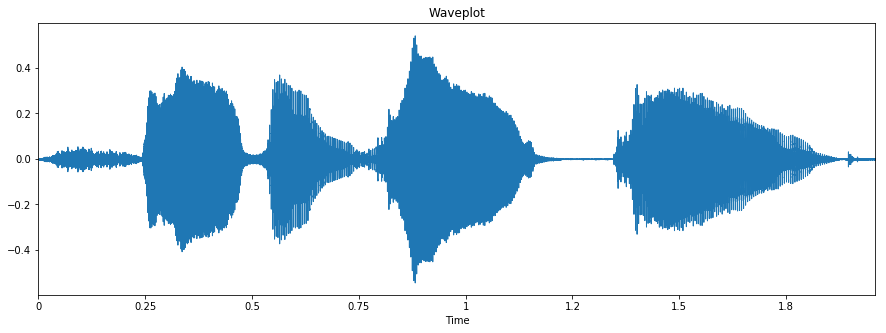

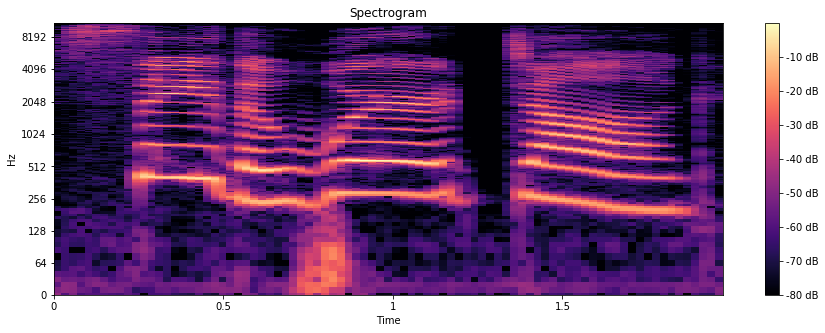

In [39]:
dir_list = os.listdir(TESS)
dir_list.sort()

# List initialization to store emotions and file paths
path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

# Dataframe creation to store emotion labels, file paths and source dataset
TESS_df = pd.DataFrame(emotion, columns = ['labels']) 
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
print(TESS_df.labels.value_counts())
print() # for an extra line

#Testing an audio sample - TESS
fname = TESS + 'YAF_happy/YAF_dog_happy.wav'

data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
plt.title('Waveplot') # Displaying Waveplot

plt.figure(figsize=(15, 5))
D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram') # Displaying Spectogram
plt.show()

ipd.Audio(fname) # Audio Playback

sad        1271
disgust    1271
fear       1271
angry      1271
happy      1271
neutral    1087
Name: labels, dtype: int64



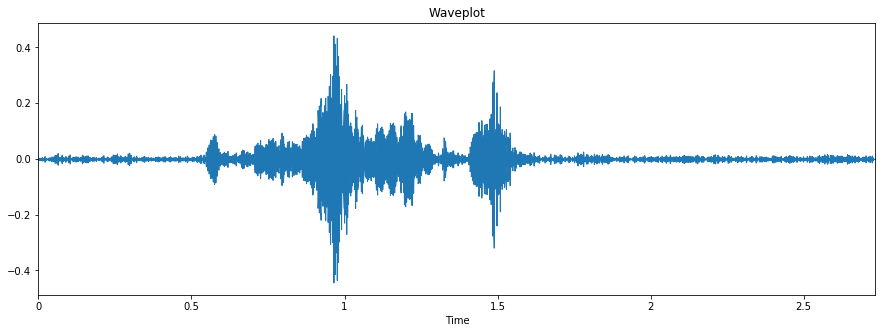

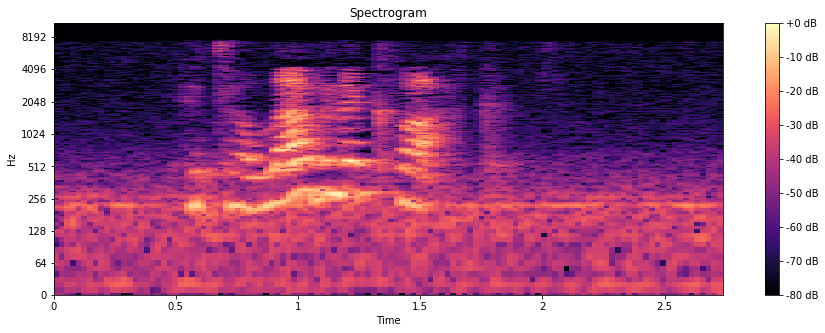

In [40]:
dir_list = os.listdir(CREMA)
dir_list.sort()

# List initialization to store emotions and file paths
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,
          1029,1030,1037,1043,1046,1047,1049,1052, 1053,1054,1055,1056,1058,1060,1061,1063, 1072,1073,1074,1075,1076,1078,1079,1082,
          1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD':
        emotion.append('sad')
    elif part[2] == 'ANG':
        emotion.append('angry')
    elif part[2] == 'DIS':
        emotion.append('disgust')
    elif part[2] == 'FEA':
        emotion.append('fear')
    elif part[2] == 'HAP':
        emotion.append('happy')
    elif part[2] == 'NEU':
        emotion.append('neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)


#Dataframe creation to store emotion labels, file paths and source dataset
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
print(CREMA_df.labels.value_counts())
print() # for an extra line

#Testing an audio sample - CREMA-D
fname = CREMA + '1012_IEO_HAP_HI.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
plt.title('Waveplot') # Displaying Waveplot

plt.figure(figsize=(15, 5))
D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram') # Displaying Spectogram
plt.show()

ipd.Audio(fname) # Audio Playback

sad         1923
disgust     1923
fear        1923
angry       1923
happy       1923
neutral     1895
surprise     652
Name: labels, dtype: int64
None


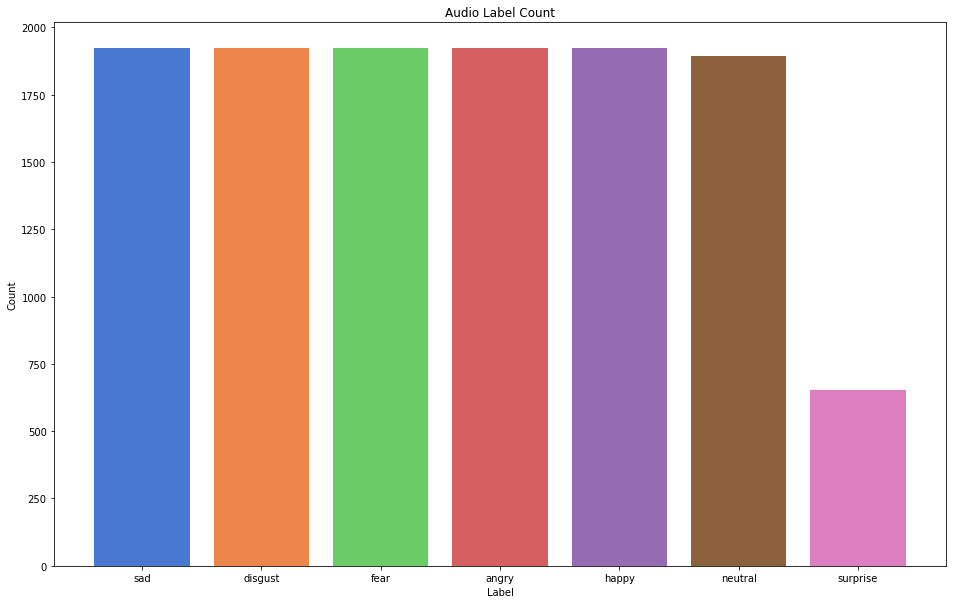

In [41]:
# Concatenate dataframes from different emotion datasets into a single dataframe
df = pd.concat([SAVEE_df, RAV_df, TESS_df, CREMA_df], axis = 0)

# Count the occurrences of each audio label
audio_label_count = df.labels.value_counts()
print(audio_label_count)
print(df.to_csv("Data_path_7.csv",index=False)) # Saving the combined dataframe to a CSV file


# Generating bar plot
colors = ['blue', 'green', 'red', 'purple', 'orange',
          'yellow', 'pink']
pastel_colors = sns.color_palette("muted", len(colors))

plt.figure(figsize=(16, 10))
plt.bar(audio_label_count.index, audio_label_count.values, color=pastel_colors)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Audio Label Count')
plt.xticks(audio_label_count.index)
plt.show()

In [42]:
ref = pd.read_csv("/kaggle/working/Data_path_7.csv")
num_mfcc = 20  # Number of MFCC coefficients
num_files = 12162  # Number of audio files

# Dataframe initialization
columns = ['mfcc_' + str(i+1) for i in range(num_mfcc)]
df = pd.DataFrame(columns=columns, index=range(num_files))
pbar = tqdm(total=num_files) # Progress bar

# Loop through audio files and extract MFCC features
for idx, path in enumerate(ref.path):  
    #Loading the audio file from the specified path and extracting MFCC features
    X, sample_rate = librosa.load(path, res_type='kaiser_fast', duration=2.5, sr=44100, offset=0.5)
    mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=num_mfcc)
    
    mfccs_mean = np.mean(mfccs, axis=1)  # Compute mean of MFCC coefficients along each column
    df.loc[idx] = mfccs_mean # Storing the mean coefficients in the dataframe
    pbar.update(1)
    
pbar.close()

100%|██████████| 12162/12162 [09:27<00:00, 21.44it/s]


In [43]:
print(df.shape)
#Concatenating the two dataframes to match the mfcc features 
#of a particular audio file to its emotion label
df_concat = pd.concat([ref, df], axis=1)
# Filling any missing values(NaN) in the dataframe with zero.
# This is done for easier handling of missing data.
df_concat=df_concat.fillna(0)
df_concat.to_csv('features_7.csv', index=False)
print(df_concat.shape)
df_concat[:5]

(12162, 20)
(12162, 23)


labels source                                               path  \
0    happy  SAVEE  /kaggle/input/surrey-audiovisual-expressed-emo...   
1     fear  SAVEE  /kaggle/input/surrey-audiovisual-expressed-emo...   
2    happy  SAVEE  /kaggle/input/surrey-audiovisual-expressed-emo...   
3  disgust  SAVEE  /kaggle/input/surrey-audiovisual-expressed-emo...   
4    angry  SAVEE  /kaggle/input/surrey-audiovisual-expressed-emo...   

       mfcc_1      mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6  \
0 -309.609619  156.562469  12.748092  24.563248   5.987000 -13.370072   
1 -621.123352  161.778122  35.570583  36.647305  25.223625  -0.475460   
2 -344.603577  113.925369  15.898048  13.738302  21.520544  13.897222   
3 -402.221893  133.746902  24.931446  36.427547  42.442593  18.489746   
4 -549.466125  154.088684  12.996944  21.621086  28.807652   4.498013   

     mfcc_7  ...    mfcc_11    mfcc_12   mfcc_13   mfcc_14   mfcc_15  \
0 -0.902566  ... -16.751169   0.902141  2.987767 -8.257284 -1.060103   
1 -0.188156  ... -13.794344  -9.369884 -3.399983 -3.791615 -1.427450   
2 -0.368703  ...  -6.870913  -9.739623 -0.659857  1.005181 -0.994036   
3  0.040821  ...  -6.487161 -17.031794 -1.840788  1.950772 -4.698260   
4 -2.225336  ...  -7.490743  -8.456983 -0.670760 -3.446213 -3.872377   

    mfcc_16   mfcc_17   mfcc_18   mfcc_19   mfcc_20  
0 -4.434721 -5.881765  4.145817 -2.087474 -8.433018  
1  1.159548  0.605723 -0.375765  4.168525  4.737456  
2 -4.372424  1.068029  4.855748 -4.877567 -3.713228  
3 -1.198288  9.812835  8.472905 -2.847432  0.185765  
4  4.194579  3.619041 -2.480716  1.123396  2.933870  

[5 rows x 23 columns]

In [44]:
extracted_features = pd.read_csv("/kaggle/working/features_7.csv")

X_train, X_test, y_train, y_test = train_test_split(extracted_features.drop(['path','labels','source'],
                                                                   axis=1)
                                                    , df_concat.labels
                                                    , test_size=0.20
                                                    , shuffle=True
                                                    , random_state=42 # Random seed for reproducibility
                                                   )

print(X_train.shape)
print(X_test.shape)

(9729, 20)
(2433, 20)


In [45]:
# Normalization of training and testing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
# Reshape input data for LSTM
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# One-hot encode the labels
label_binarizer = LabelBinarizer()
y_train_one_hot = label_binarizer.fit_transform(y_train)
y_test_one_hot = label_binarizer.transform(y_test)
num_classes = 7

# Defining the LSTM model
lstm_model = Sequential([
    LSTM(units=128, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  # Use 'softmax' activation for multi-class classification
])

# Compiling the model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = lstm_model.fit(X_train_reshaped, y_train_one_hot, epochs=100, batch_size=8, validation_data=(X_test_reshaped, y_test_one_hot))

# Evaluating the model and calculate accuracy
loss, accuracy = lstm_model.evaluate(X_test_reshaped, y_test_one_hot)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Train on 9729 samples, validate on 2433 samples
Epoch 1/100
9729/9729 [==============================] - 7s 673us/sample - loss: 1.4745 - acc: 0.4148 - val_loss: 1.2717 - val_acc: 0.5080
Epoch 2/100
9729/9729 [==============================] - 6s 597us/sample - loss: 1.2765 - acc: 0.4836 - val_loss: 1.1954 - val_acc: 0.5368
Epoch 3/100
9729/9729 [==============================] - 6s 595us/sample - loss: 1.2250 - acc: 0.5046 - val_loss: 1.1560 - val_acc: 0.5545
Epoch 4/100
9729/9729 [==============================] - 6s 602us/sample - loss: 1.1926 - acc: 0.5233 - val_loss: 1.1376 - val_acc: 0.5516
Epoch 5/100
9729/9729 [==============================] - 6s 614us/sample - loss: 1.1666 - acc: 0.5336 - val_loss: 1.1357 - val_acc: 0.5499
Epoch 6/100
9729/9729 [==============================] - 6s 592us/sample - loss: 1.1569 - acc: 0.5336 - val_loss: 1.1160 - val_acc: 0.5561
Epoch 7/100
9729/9729 [==============================] - 6s 595us/sample - loss: 1.1399 - acc: 0.5454 - val_loss: 1.10

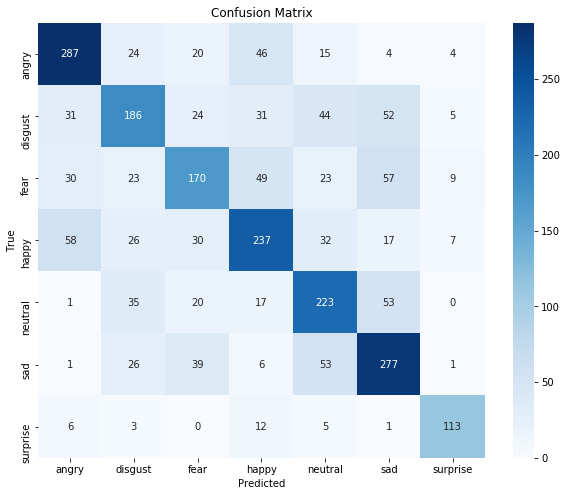

In [47]:
# Predict probabilities for the test set
y_pred_probs = lstm_model.predict(X_test_reshaped)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=label_binarizer.classes_, yticklabels=label_binarizer.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

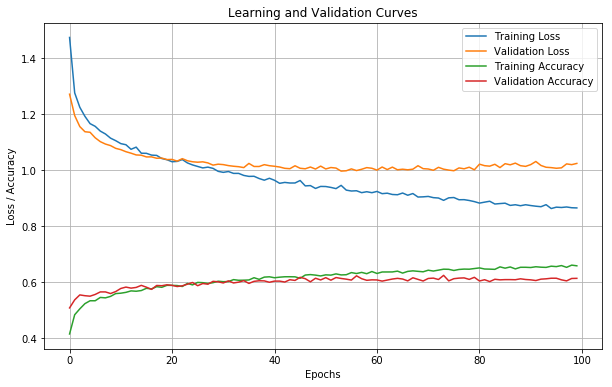

In [48]:
# Plot learning and validation curves on the same graph
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Learning and Validation Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# Make predictions on the test set
y_pred = lstm_model.predict_classes(X_test_reshaped)
# Convert one-hot encoded labels to integers
y_test_classes = np.argmax(y_test_one_hot, axis=1)
# Generate classification report
classification_rep = classification_report(y_test_classes, y_pred)
# Print the classification report
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.72      0.71       400
           1       0.58      0.50      0.53       373
           2       0.56      0.47      0.51       361
           3       0.60      0.58      0.59       407
           4       0.56      0.64      0.60       349
           5       0.60      0.69      0.64       403
           6       0.81      0.81      0.81       140

    accuracy                           0.61      2433
   macro avg       0.63      0.63      0.63      2433
weighted avg       0.61      0.61      0.61      2433



In [50]:
#Saving model to disk
model_path = "lstm_model_7.h5"
lstm_model.save(model_path)

print("Model saved at /kaggle/working/")

Model saved at /kaggle/working/


## KNN Model

In [51]:
#KNN classifier
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')  

# Training
knn.fit(X_train_scaled, y_train)

# Predict labels 
y_pred = knn.predict(X_test_scaled)

# Evaluating the classifier and calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5277435265104808


## SVM Model

In [52]:
X_train_array = np.array(X_train)
X_test_array = np.array(X_test)

# Reshape the array if necessary
X_train_flattened = X_train_array.reshape(X_train_array.shape[0], -1)
X_test_flattened = X_test_array.reshape(X_test_array.shape[0], -1)

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the SVM classifier
svm_classifier.fit(X_train_flattened, y_train)

# Predict labels for test data
y_pred_svm = svm_classifier.predict(X_test_flattened)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy_svm)

Accuracy: 0.4726674886970818
